In [3]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from torch.utils.data import Dataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

import warnings
warnings.filterwarnings('ignore')

In [98]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length, use_rope_scaling, num_samples):
    ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [210]:
class CategoryDataset(PandasDataset):
    def __init__(self, file, category):
        self.data = pd.read_csv(file, index_col=0, parse_dates=True)
        self.datasets = {}
        self.forecasts = {}
        self.tss = {}
        self.eval_agg_metrics = {}
        self.eval_ts_metrics = {}
        for cg, group in self.data.groupby(category):
            df = group.drop(columns=[category])
            for col in df.columns:
                if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
                    df[col] = df[col].astype('float32')

            # print(df)
            self.datasets[cg] = PandasDataset(dict(df))
            # print(self.datasets[cg])
            self.forecasts[cg] = []
            self.tss[cg] = []
            self.eval_agg_metrics[cg] = None
            self.eval_ts_metrics[cg] = None

    def prepare_data(self):
        pass

    def plot(self, cg):
        plt.figure(figsize=(20, 15))
        date_formater = mdates.DateFormatter('%b, %d')
        plt.rcParams.update({'font.size': 15})
        
        # Iterate through the first 9 series, and plot the predicted samples
        forecasts = self.forecasts[cg]
        tss = self.tss[cg]
        for idx, (forecast, ts) in enumerate(zip(forecasts, tss)):
            ax = plt.subplot(len(self.forecasts) // 3 + 1, 3, idx+1)
            plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="Ground Truth", )
            forecast.plot( color='g')
            plt.xticks(rotation=60)
            ax.xaxis.set_major_formatter(date_formater)
            ax.set_title(forecast.item_id)
            ax.set_xlabel(f"Series - {cg} - {idx+1}")
            ax.set_ylabel("Trend")
        
        plt.gcf().tight_layout()
        plt.legend()
        plt.show()
    
    
    def show_shape(self, cg):
        forecasts = self.forecasts[cg]
        tss = self.tss[cg]
        print(len(forecasts), forecasts[0].samples.shape, len(tss), tss[0].shape)
        print(forecasts[0])


    # def eval(self, cg):
    #     evaluator = Evaluator()
    #     forecasts = self.forecasts[cg]
    #     tss = self.tss[cg]
    #     self.eval_agg_metrics[cg], self.eval_ts_metrics[cg] = evaluator(iter(tss), iter(forecasts))
    #     print(f"CRPS: {self.eval_agg_metrics['mean_wQuantileLoss']}")

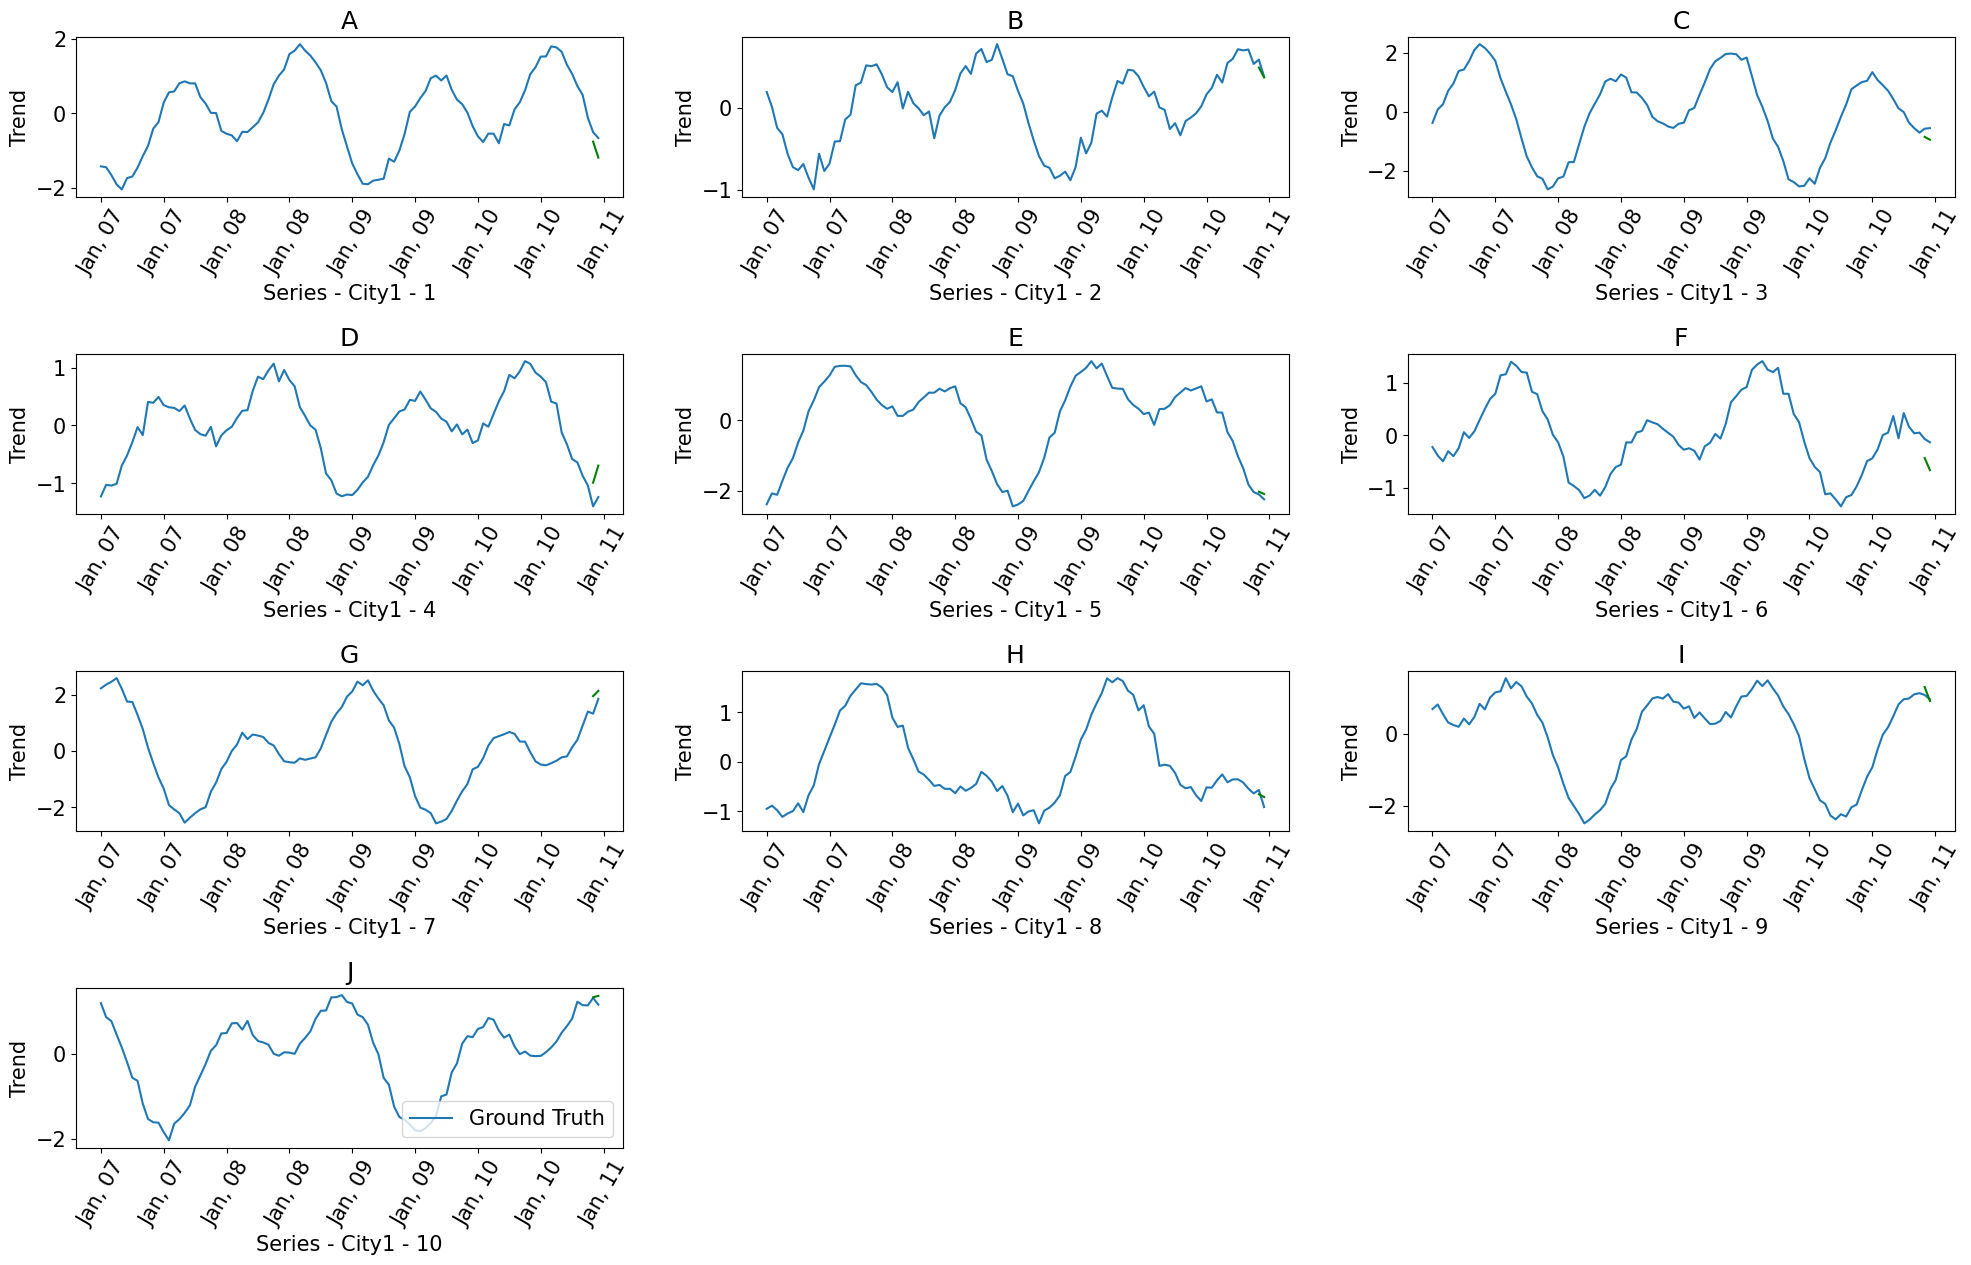

In [217]:
file = 'dataset/ts_wide_category_city_varient.csv'
category = 'City'
ds = CategoryDataset(file, category)
# print(ds.datasets.keys())
for cg in ds.datasets.keys():
    # print(ds.datasets[cg])
    ds.forecasts[cg], ds.tss[cg] = get_lag_llama_predictions(ds.datasets[cg], \
                                                             prediction_length=2, \
                                                             device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), \
                                                             context_length=12, \
                                                             use_rope_scaling=False, \
                                                             num_samples=1)
    # ds.show_shape(cg)
    ds.plot(cg)
    # ds.eval(cg)
    break